In [ ]:
import os
import glob
import pandas as pd
import geopandas as gpd
import warnings

# Ignore common warnings from geopandas
warnings.filterwarnings('ignore')

# --- Configuration ---

# Define the target Coordinate Reference System (CRS) for all operations
TARGET_CRS = "epsg:3571"

# Years to loop through
years = range(2012, 2026) # Processing years 2012 through 2025

# Base output path where subfolders for each region will be created
base_out_path = '/explore/nobackup/people/spotter5/for_reporters/viirs_by_day_multiple_aoi'
os.makedirs(base_out_path, exist_ok = True)

# --- Load and Prepare all AOI Shapefiles ---
print("Loading and preparing Area of Interest (AOI) shapefiles...")
shapefile_info = [
    ('circumpolar', '/explore/nobackup/people/spotter5/viirs_nrt/shared_data/shapefiles/circumpolar.gpkg'),
    ('siberia', '/explore/nobackup/people/spotter5/arctic_report_card/shapes/Siberia/Siberia_Domain_V1_dissolved.shp'),
    # ('europe_russia', '/explore/nobackup/people/spotter5/arctic_report_card/shapes/europe_russia.shp'),
    ('alaska', '/explore/nobackup/people/spotter5/arctic_report_card/shapes/ak_permafrost.shp'),
    ('canada', '/explore/nobackup/people/spotter5/arctic_report_card/shapes/ca_permafrost_bor_tun.shp'),
    # ('boreal', '/explore/nobackup/people/spotter5/Moore/raw/boreal_final.shp'),
    # ('tundra', '/explore/nobackup/people/spotter5/Moore/raw/tundra_final.shp'),
    # ('brown', '/explore/nobackup/people/spotter5/arctic_report_card/shapes/tundra_and_boreal_permafrost.shp')
]

# Load all AOIs into a list, reprojecting them to the target CRS
prepared_aois = []
for name, path in shapefile_info:
    try:
        aoi_gdf = gpd.read_file(path).to_crs(TARGET_CRS)
        # Fix any invalid geometries in the AOI
        aoi_gdf['geometry'] = aoi_gdf['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)
        prepared_aois.append((name, aoi_gdf))
        print(f"  - Successfully loaded and prepared '{name}'")
    except Exception as e:
        print(f"  - Failed to load AOI '{name}' from {path}. Error: {e}")

# --- Main Processing Loop ---

for year in years:
    print(f"\n--- Processing Year: {year} ---")

    # 1. Determine input paths and gather all files for the year
    all_files = []
    if year >= 2024:
        print(f"Using new paths for {year} and concatenating sources.")
        # For 2024+, merge data from two sources (ak_ca and eurasia)
        in_path_ak_ca = f"/explore/nobackup/people/spotter5/viirs_nrt/2_pipeline/ak_ca/{year}/Snapshot"
        in_path_ea = f"/explore/nobackup/people/spotter5/viirs_nrt/2_pipeline/ea/{year}/Snapshot"
        all_files.extend(glob.glob(os.path.join(in_path_ak_ca, '*.gpkg')))
        all_files.extend(glob.glob(os.path.join(in_path_ea, '*.gpkg')))
    else:
        # For years before 2024, use the historical fire atlas
        in_path_historical = f"/explore/nobackup/people/spotter5/viirs_nrt/rebecca_historical/fire_atlas/fire_atlas/{year}/Snapshot"
        all_files = glob.glob(os.path.join(in_path_historical, '*.gpkg'))

    # Filter out files containing "_FL" or "_NFP" in their names
    filtered_files = [f for f in all_files if not ("_FL" in f or "_NFP" in f)]
    
    if not filtered_files:
        print(f"No valid data files found for {year}. Skipping.")
        continue
    
    print(f"Found {len(filtered_files)} files to process for {year}.")

    # 2. Read and concatenate all fire data for the year
    yearly_fire_data = []
    for f in filtered_files:
        try:
            in_df = gpd.read_file(f)[['fireid', 'farea', 'tst_year', 'ted_doy', 'geometry']]
            yearly_fire_data.append(in_df)
        except Exception as e:
            print(f"Error processing file {f}: {e}")
    
    # Proceed only if data was successfully read
    if yearly_fire_data:
        # Concatenate into a single GeoDataFrame
        full_year_gdf = pd.concat(yearly_fire_data, ignore_index=True)
        full_year_gdf = gpd.GeoDataFrame(full_year_gdf, geometry='geometry')
        full_year_gdf.set_crs(gpd.read_file(filtered_files[0]).crs, inplace=True)

        # 3. Process the combined yearly data
        print("Fixing geometries and reprojecting yearly data...")
        # Check and fix invalid geometries
        full_year_gdf['geometry'] = full_year_gdf['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)
        # Reproject to the target CRS
        full_year_gdf = full_year_gdf.to_crs(TARGET_CRS)

        # 4. Loop through each prepared AOI, clip, and save
        for aoi_name, aoi_gdf in prepared_aois:
            print(f"  Clipping to '{aoi_name}'...")
            
            # Create the specific output directory for the AOI
            aoi_out_path = os.path.join(base_out_path, aoi_name)
            os.makedirs(aoi_out_path, exist_ok=True)
            
            # Clip the processed yearly data to the current AOI
            clipped_gdf = gpd.clip(full_year_gdf, aoi_gdf)

            # Ensure there is data after clipping
            if not clipped_gdf.empty:
                # Convert km2 to Mha (Megahectares)
                clipped_gdf['farea'] = (clipped_gdf['farea'] * 100) / 1e6
                
                # Define the final output file path
                out_filepath = os.path.join(aoi_out_path, f"{year}.shp")
                
                # Save the final clipped GeoDataFrame to a shapefile
                clipped_gdf.to_file(out_filepath)
                print(f"    ✅ Saved output to {out_filepath}")
            else:
                print(f"    - No data for '{aoi_name}' in {year} after clipping.")

print("\n🎉 All years processed.")

Loading and preparing Area of Interest (AOI) shapefiles...
  - Successfully loaded and prepared 'circumpolar'


In [ ]:
't'


RUNNING COMPARISON ANALYSIS FOR: NEE
--- Running CatBoost LOSO ---
  Processing site: Hakasia 5yr_RU-Ha2_tower...
  Processing site: Hakasia Steppe_RU-Ha1_tower...
  Processing site: Kaamanen_FI-Kaa_tower...
  Processing site: Manitoba - Northern Old Black Spruce (former BOREAS Northern Study Area)_CA-Man_tower...
  Processing site: Nelegel_RU-Nel_tower...
  Processing site: Neleger Cutover_RU-NeC_tower...
  Processing site: Neleger larch forest_RU-NeF_tower...
  Processing site: Saskatchewan - Western Boreal, forest burned in 1989_CA-SF2_tower...
  Processing site: Sodankyla_FI-Sod_tower...
  Processing site: UCI-1850 burn site_CA-NS1_tower...
  Processing site: UCI-1964 burn site_CA-NS3_tower...
  Processing site: UCI-1981 burn site_CA-NS5_tower...
  Processing site: UCI-1989 burn site_CA-NS6_tower...
  Processing site: UCI-1998 burn site_CA-NS7_tower...
  Processing site: UCI-1964 burn site wet_CA-NS4_tower...
  Processing site: Delta Junction  evergreen conifer forest_US-Bn2_tower

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Pond Inlet_CA-Pin_tower...


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Poker Flat Research Range: Succession from fire scar to deciduous forest_US-Rpf_tower...
  Processing site: Samoylov Island_RU-Sam (open)_tower...
  Processing site: Udleg practice forest_MN-Udg_tower...
  Processing site: Daring Lake_CA-DL3_tower...
  Processing site: Elgeeii forest station_RU-Ege_tower...
  Processing site: Bonanza Creek Black Spruce_US-BZS_tower...
  Processing site: Daring Lake_CA-DL4_tower...
  Processing site: Tiksi_RU-Tks_tower...
  Processing site: Samoylov Island_RU-Sam (closed)_tower...
  Processing site: Bonanza Creek Thermokarst Bog_US-BZB_tower...
  Processing site: Poker Flat Research Range Black Spruce Forest_US-Prr_tower...
  Processing site: Bonanza Creek Rich Fen_US-BZF_tower...
  Processing site: Cascaden Ridge Fire Scar_US-Fcr_tower...


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Lake Hazen, Ellesmere Island_CA-LHazen2-meadow wetland_tower...
  Processing site: Cherskii ecotone_RU-Eusk_cher1_tower...
  Processing site: Sammaltunturi fell_FI-SamFell_tower...
  Processing site: ARM-NSA-Barrow_US-A10_tower...
  Processing site: Adventdalen_SJ-Adv_tower...
  Processing site: Stordalen Fen_SE-St1_tower...
  Processing site: NGEE Arctic Barrow_US-NGB_tower...
  Processing site: Cherskii disturbed forest_RU-Eusk_cher2_tower...
  Processing site: Disko_GL-Dsk_tower...
  Processing site: Havikpak Creek_CA-HPC_tower...
  Processing site: Scotty Creek Landscape_CA-SCC_tower...
  Processing site: ZOTTO Bog_RU-Zo1_tower...
  Processing site: ZOTTO Forest_RU-Zo2_tower...
  Processing site: Trail Valley Creek_CA-TVC_tower...
  Processing site: Cherskii reference_RU-Ch2_tower...
  Processing site: Flux Observations of Carbon from an Airborne Laboratory (FOCAL) Campaign Site 1_US-Fo1_tower...
  Processing site: Barrow-CMDL_US-Brw_tower...
  Processing site: S

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Pond Inlet_CA-Pin_tower...


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Poker Flat Research Range: Succession from fire scar to deciduous forest_US-Rpf_tower...
  Processing site: Samoylov Island_RU-Sam (open)_tower...
  Processing site: Udleg practice forest_MN-Udg_tower...
  Processing site: Daring Lake_CA-DL3_tower...
  Processing site: Elgeeii forest station_RU-Ege_tower...
  Processing site: Bonanza Creek Black Spruce_US-BZS_tower...
  Processing site: Daring Lake_CA-DL4_tower...
  Processing site: Tiksi_RU-Tks_tower...
  Processing site: Samoylov Island_RU-Sam (closed)_tower...
  Processing site: Bonanza Creek Thermokarst Bog_US-BZB_tower...
  Processing site: Poker Flat Research Range Black Spruce Forest_US-Prr_tower...
  Processing site: Bonanza Creek Rich Fen_US-BZF_tower...
  Processing site: Cascaden Ridge Fire Scar_US-Fcr_tower...
  Processing site: Lake Hazen, Ellesmere Island_CA-LHazen2-meadow wetland_tower...
  Processing site: Cherskii ecotone_RU-Eusk_cher1_tower...
  Processing site: Kenttarova_FI-Ken_tower...
  Processi

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




          FINAL POOLED METRICS COMPARISON (NEE)
        CatBoost     SVM
Metric                  
R²        0.5053  0.5261
RMSE     22.5007 20.1410
MAE      15.2575 13.1604

--- Generating Comparison Plots ---


KeyError: False

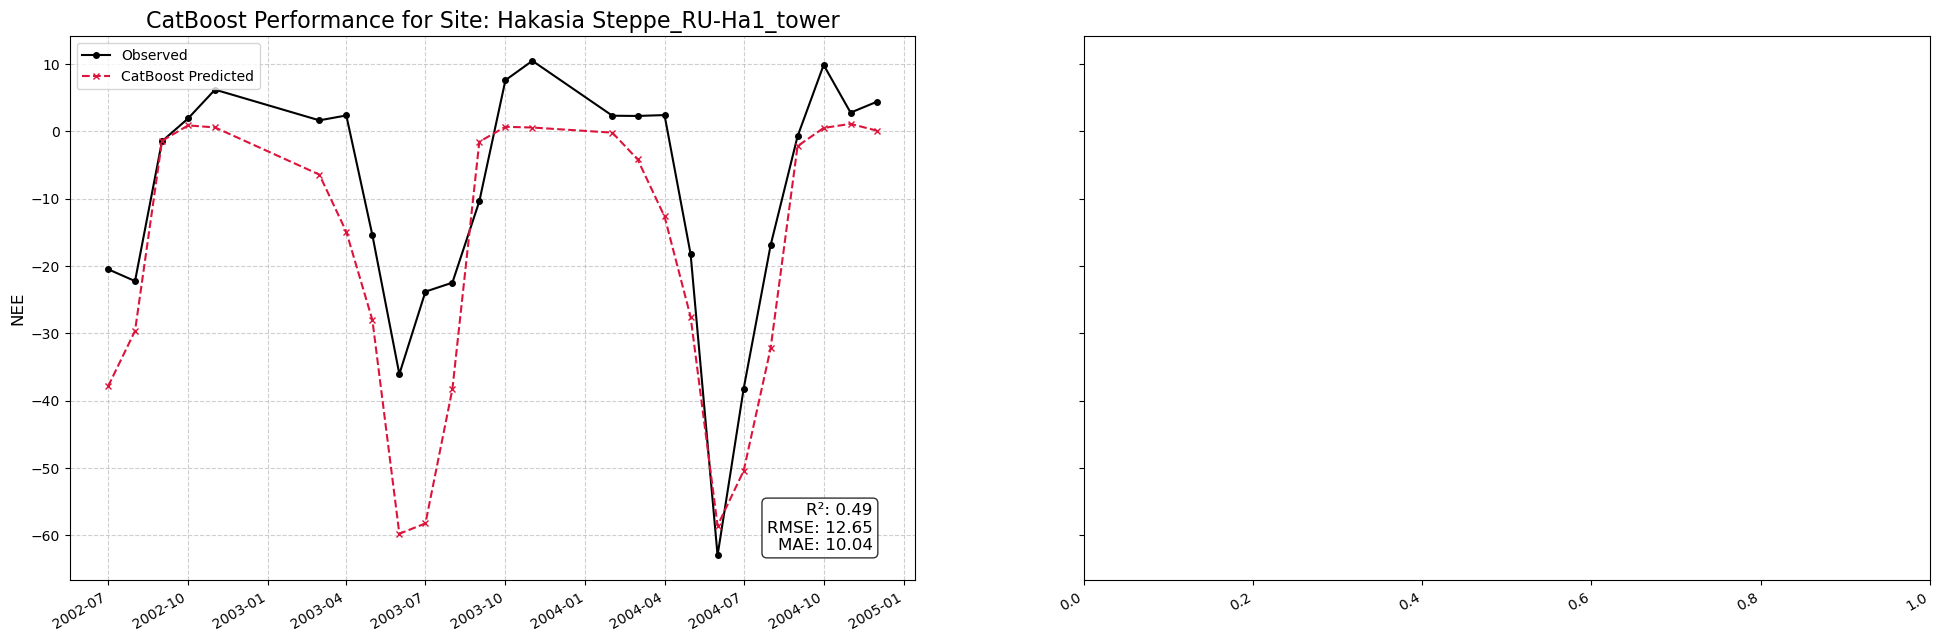

In [3]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor

# Suppress warnings
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
warnings.filterwarnings("ignore", category=FutureWarning)

def run_catboost_loso(df, feature_cols, categorical_features, target_col):
    """Runs LOSO CV for CatBoost and returns predictions and metrics."""
    print("--- Running CatBoost LOSO ---")
    X = df[feature_cols].copy()
    y = df[target_col]
    sites = df["site_reference"].unique()

    for col in categorical_features:
        X[col] = X[col].astype('category')

    results = []
    all_preds_df_list = []

    for test_site in sites:
        print(f"  Processing site: {test_site}...")
        train_idx = df["site_reference"] != test_site
        test_idx = df["site_reference"] == test_site
        
        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        # --- FIX: Corrected CatBoost parameters ---
        model = CatBoostRegressor(iterations=1200, learning_rate=0.01, depth=8, subsample=0.7,
                                  random_seed=42,  # Correct parameter for reproducibility
                                  l2_leaf_reg=0.1, 
                                  rsm=0.8,         # Correct parameter for feature sampling
                                  cat_features=categorical_features, 
                                  verbose=0, 
                                  allow_writing_files=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        site_df = pd.DataFrame({"Site": test_site, "Date": df.loc[test_idx, "date"], 
                                "Observed": y_test, "Predicted": y_pred})
        all_preds_df_list.append(site_df)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({"Site": test_site, "RMSE": rmse, "MAE": mae, "R2": r2})

    return pd.DataFrame(results), pd.concat(all_preds_df_list, ignore_index=True)

def run_svm_loso(df, feature_cols, target_col):
    """Runs LOSO CV for SVM and returns predictions and metrics."""
    print("--- Running SVM LOSO ---")
    X_initial = df[feature_cols].copy()
    y = df[target_col]
    sites = df["site_reference"].unique()
    
    categorical_features = [f for f in X_initial.select_dtypes(include=['category', 'object']).columns if f in feature_cols]
    X = pd.get_dummies(X_initial, columns=categorical_features, drop_first=True) if categorical_features else X_initial

    results = []
    all_preds_df_list = []

    for test_site in sites:
        print(f"  Processing site: {test_site}...")
        train_idx = df["site_reference"] != test_site
        test_idx = df["site_reference"] == test_site

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        site_df = pd.DataFrame({"Site": test_site, "Date": df.loc[test_idx, "date"],
                                "Observed": y_test, "Predicted": y_pred})
        all_preds_df_list.append(site_df)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({"Site": test_site, "RMSE": rmse, "MAE": mae, "R2": r2})
        
    return pd.DataFrame(results), pd.concat(all_preds_df_list, ignore_index=True)

def generate_comparison_plots(catboost_preds, svm_preds, catboost_metrics, svm_metrics, target_col, figures_path):
    """Generates 1x2 side-by-side comparison plots for each site."""
    print("\n--- Generating Comparison Plots ---")
    all_sites = catboost_preds["Site"].unique()
    
    for site in all_sites:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

        # Left Panel: CatBoost
        cb_site_df = catboost_preds[catboost_preds["Site"] == site].sort_values("Date")
        cb_metrics = catboost_metrics[catboost_metrics["Site"] == site].iloc[0]
        ax1.plot(cb_site_df["Date"], cb_site_df["Observed"], label="Observed", marker="o", linestyle='-', c='black', markersize=4)
        ax1.plot(cb_site_df["Date"], cb_site_df["Predicted"], label="CatBoost Predicted", marker="x", linestyle='--', c='crimson', markersize=4)
        ax1.set_title(f"CatBoost Performance for Site: {site}", fontsize=16)
        ax1.set_ylabel(target_col.upper(), fontsize=12)
        ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.6); fig.autofmt_xdate()
        cb_text = f"R²: {cb_metrics['R2']:.2f}\nRMSE: {cb_metrics['RMSE']:.2f}\nMAE: {cb_metrics['MAE']:.2f}"
        ax1.text(0.95, 0.05, cb_text, transform=ax1.transAxes, fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        # Right Panel: SVM
        svm_site_df = svm_preds[svm_preds["Site"] == site].sort_values("Date")
        svm_metrics = svm_metrics[svm_metrics["Site"] == site].iloc[0]
        ax2.plot(svm_site_df["Date"], svm_site_df["Observed"], label="Observed", marker="o", linestyle='-', c='black', markersize=4)
        ax2.plot(svm_site_df["Date"], svm_site_df["Predicted"], label="SVM Predicted", marker="x", linestyle='--', c='royalblue', markersize=4)
        ax2.set_title(f"SVM Performance for Site: {site}", fontsize=16)
        ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.6)
        svm_text = f"R²: {svm_metrics['R2']:.2f}\nRMSE: {svm_metrics['RMSE']:.2f}\nMAE: {svm_metrics['MAE']:.2f}"
        ax2.text(0.95, 0.05, svm_text, transform=ax2.transAxes, fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        plot_filename = f'comparison_{target_col}_{site}.png'
        plot_path = os.path.join(figures_path, plot_filename)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close(fig)

    print(f"All comparison plots saved to: {figures_path}")

if __name__ == '__main__':
    TARGET_COL = 'nee'
    
    print(f"\n{'='*50}\nRUNNING COMPARISON ANALYSIS FOR: {TARGET_COL.upper()}\n{'='*50}")

    base_path = "/explore/nobackup/people/spotter5/anna_v/v2/loocv"
    full_dataset_path = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv"
    df_full = pd.read_csv(full_dataset_path)

    df_full['land_cover'] = df_full['land_cover'].astype('category')
    # df_full['month'] = df_full['month'].astype('category')
    df_full['land_cover'] = df_full['land_cover'].astype(int)
    df_full['month'] = df_full['month'].astype(int)
    df_full = df_full[df_full['flux_method'] == 'EC']
    df_full['tmean_C'] = df_full[['tmmn', 'tmmx']].mean(axis=1)
    df_full['date'] = pd.to_datetime(df_full[['year', 'month']].assign(day=1))
    
    catboost_feature_cols = [
        'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07', 'NDWI', 'pdsi', 
        'srad', 'tmean_C', 'vap', 'vs', 'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm', 
        'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm', 'silt_0_100cm', 
        'soc_0_100cm', 'co2_cont', 'ALT', 'land_cover', 'month', 'lai', 'fpar', 
        'Percent_NonTree_Vegetation', 'Percent_NonVegetated', 'Percent_Tree_Cover'
    ]
    catboost_categorical_features = ['land_cover', 'month']

    top_features_path = os.path.join(base_path, TARGET_COL, f'training_data_{TARGET_COL}_top_preds.csv')
    try:
        top_features_df = pd.read_csv(top_features_path)
        svm_feature_cols = [col for col in top_features_df.columns if col != TARGET_COL]
    except FileNotFoundError:
        print(f"FATAL ERROR: Top features file for SVM not found at {top_features_path}")
        exit()

    df_catboost = df_full.dropna(subset=catboost_feature_cols + [TARGET_COL, 'site_reference'])
    df_svm = df_full.dropna(subset=svm_feature_cols + [TARGET_COL, 'site_reference'])
    
    catboost_metrics_df, catboost_preds_df = run_catboost_loso(df_catboost, catboost_feature_cols, catboost_categorical_features, TARGET_COL)
    svm_metrics_df, svm_preds_df = run_svm_loso(df_svm, svm_feature_cols, TARGET_COL)
    
    # --- FIX: Calculate and Print Pooled Metrics Comparison ---
    
    # Calculate pooled metrics for CatBoost
    cb_r2_all = r2_score(catboost_preds_df["Observed"], catboost_preds_df["Predicted"])
    cb_rmse_all = np.sqrt(mean_squared_error(catboost_preds_df["Observed"], catboost_preds_df["Predicted"]))
    cb_mae_all = mean_absolute_error(catboost_preds_df["Observed"], catboost_preds_df["Predicted"])
    
    # Calculate pooled metrics for SVM
    svm_r2_all = r2_score(svm_preds_df["Observed"], svm_preds_df["Predicted"])
    svm_rmse_all = np.sqrt(mean_squared_error(svm_preds_df["Observed"], svm_preds_df["Predicted"]))
    svm_mae_all = mean_absolute_error(svm_preds_df["Observed"], svm_preds_df["Predicted"])
    
    # Create a DataFrame for the comparison table
    summary_data = {
        'Metric': ['R²', 'RMSE', 'MAE'],
        'CatBoost': [cb_r2_all, cb_rmse_all, cb_mae_all],
        'SVM': [svm_r2_all, svm_rmse_all, svm_mae_all]
    }
    summary_df = pd.DataFrame(summary_data).set_index('Metric')
    
    print("\n\n" + "="*60)
    print(f"          FINAL POOLED METRICS COMPARISON ({TARGET_COL.upper()})")
    print("="*60)
    print(summary_df.to_string(float_format="%.4f"))
    print("="*60)

    # --- Generate Plots ---
    comparison_figures_path = os.path.join(base_path, TARGET_COL, "figures", "svm_v_cat_modeled")
    os.makedirs(comparison_figures_path, exist_ok=True)
    generate_comparison_plots(catboost_preds_df, svm_preds_df, catboost_metrics_df, svm_metrics_df, TARGET_COL, comparison_figures_path)

    print(f"\n{'='*50}\nCOMPLETED COMPARISON ANALYSIS FOR: {TARGET_COL.upper()}\n{'='*50}")


RUNNING COMPARISON ANALYSIS FOR: NEE
--- Running CatBoost LOSO ---
  Processing site: Hakasia 5yr_RU-Ha2_tower...
  Processing site: Hakasia Steppe_RU-Ha1_tower...
  Processing site: Kaamanen_FI-Kaa_tower...
  Processing site: Manitoba - Northern Old Black Spruce (former BOREAS Northern Study Area)_CA-Man_tower...
  Processing site: Nelegel_RU-Nel_tower...
  Processing site: Neleger Cutover_RU-NeC_tower...
  Processing site: Neleger larch forest_RU-NeF_tower...
  Processing site: Saskatchewan - Western Boreal, forest burned in 1989_CA-SF2_tower...
  Processing site: Sodankyla_FI-Sod_tower...
  Processing site: UCI-1850 burn site_CA-NS1_tower...
  Processing site: UCI-1964 burn site_CA-NS3_tower...
  Processing site: UCI-1981 burn site_CA-NS5_tower...
  Processing site: UCI-1989 burn site_CA-NS6_tower...
  Processing site: UCI-1998 burn site_CA-NS7_tower...
  Processing site: UCI-1964 burn site wet_CA-NS4_tower...
  Processing site: Delta Junction  evergreen conifer forest_US-Bn2_tower

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Pond Inlet_CA-Pin_tower...


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Poker Flat Research Range: Succession from fire scar to deciduous forest_US-Rpf_tower...
  Processing site: Samoylov Island_RU-Sam (open)_tower...
  Processing site: Udleg practice forest_MN-Udg_tower...
  Processing site: Daring Lake_CA-DL3_tower...
  Processing site: Elgeeii forest station_RU-Ege_tower...
  Processing site: Bonanza Creek Black Spruce_US-BZS_tower...
  Processing site: Daring Lake_CA-DL4_tower...
  Processing site: Tiksi_RU-Tks_tower...
  Processing site: Samoylov Island_RU-Sam (closed)_tower...
  Processing site: Bonanza Creek Thermokarst Bog_US-BZB_tower...
  Processing site: Poker Flat Research Range Black Spruce Forest_US-Prr_tower...
  Processing site: Bonanza Creek Rich Fen_US-BZF_tower...
  Processing site: Cascaden Ridge Fire Scar_US-Fcr_tower...


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Lake Hazen, Ellesmere Island_CA-LHazen2-meadow wetland_tower...
  Processing site: Cherskii ecotone_RU-Eusk_cher1_tower...
  Processing site: Sammaltunturi fell_FI-SamFell_tower...
  Processing site: ARM-NSA-Barrow_US-A10_tower...
  Processing site: Adventdalen_SJ-Adv_tower...
  Processing site: Stordalen Fen_SE-St1_tower...
  Processing site: NGEE Arctic Barrow_US-NGB_tower...
  Processing site: Cherskii disturbed forest_RU-Eusk_cher2_tower...
  Processing site: Disko_GL-Dsk_tower...
  Processing site: Havikpak Creek_CA-HPC_tower...
  Processing site: Scotty Creek Landscape_CA-SCC_tower...
  Processing site: ZOTTO Bog_RU-Zo1_tower...
  Processing site: ZOTTO Forest_RU-Zo2_tower...
  Processing site: Trail Valley Creek_CA-TVC_tower...
  Processing site: Cherskii reference_RU-Ch2_tower...
  Processing site: Flux Observations of Carbon from an Airborne Laboratory (FOCAL) Campaign Site 1_US-Fo1_tower...
  Processing site: Barrow-CMDL_US-Brw_tower...
  Processing site: S

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Pond Inlet_CA-Pin_tower...


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  Processing site: Poker Flat Research Range: Succession from fire scar to deciduous forest_US-Rpf_tower...
  Processing site: Samoylov Island_RU-Sam (open)_tower...
  Processing site: Udleg practice forest_MN-Udg_tower...
  Processing site: Daring Lake_CA-DL3_tower...
  Processing site: Elgeeii forest station_RU-Ege_tower...
  Processing site: Bonanza Creek Black Spruce_US-BZS_tower...
  Processing site: Daring Lake_CA-DL4_tower...
  Processing site: Tiksi_RU-Tks_tower...
  Processing site: Samoylov Island_RU-Sam (closed)_tower...
  Processing site: Bonanza Creek Thermokarst Bog_US-BZB_tower...
  Processing site: Poker Flat Research Range Black Spruce Forest_US-Prr_tower...
  Processing site: Bonanza Creek Rich Fen_US-BZF_tower...
  Processing site: Cascaden Ridge Fire Scar_US-Fcr_tower...
  Processing site: Lake Hazen, Ellesmere Island_CA-LHazen2-meadow wetland_tower...
  Processing site: Cherskii ecotone_RU-Eusk_cher1_tower...
  Processing site: Kenttarova_FI-Ken_tower...
  Processi

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)




          FINAL POOLED METRICS COMPARISON (NEE)
        CatBoost (All Features)  SVM (Top Features)
Metric                                             
R²                       0.5053              0.5261
RMSE                    22.5007             20.1410
MAE                     15.2575             13.1604

--- Generating Comparison Plots ---


KeyError: False

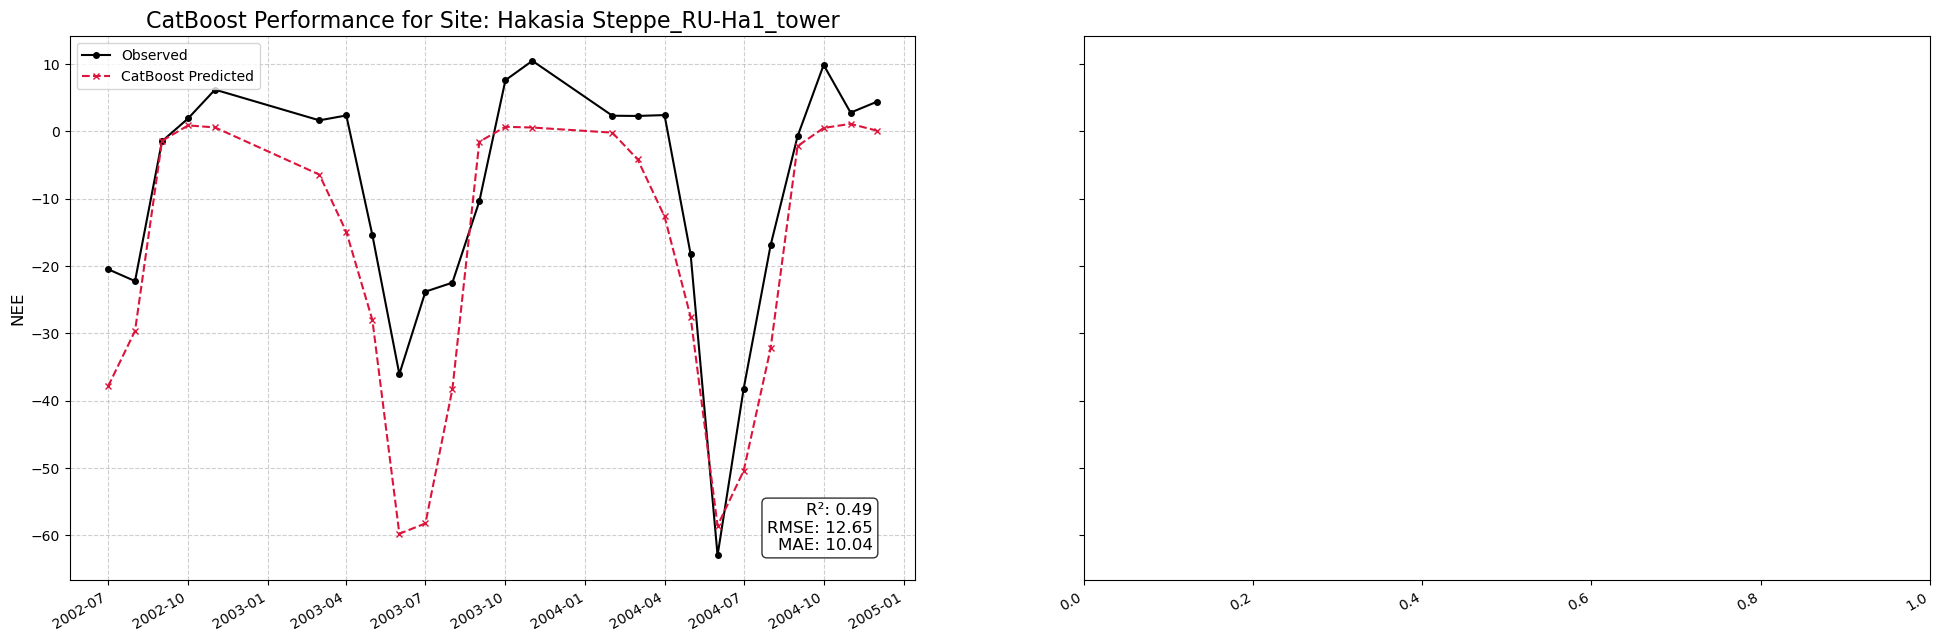

In [5]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor

# Suppress warnings
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
warnings.filterwarnings("ignore", category=FutureWarning)

def run_catboost_loso(df, feature_cols, categorical_features, target_col):
    """Runs LOSO CV for CatBoost and returns predictions and metrics."""
    print("--- Running CatBoost LOSO ---")
    X = df[feature_cols].copy()
    y = df[target_col]
    sites = df["site_reference"].unique()

    for col in categorical_features:
        X[col] = X[col].astype('category')

    results = []
    all_preds_df_list = []

    for test_site in sites:
        print(f"  Processing site: {test_site}...")
        train_idx = df["site_reference"] != test_site
        test_idx = df["site_reference"] == test_site
        
        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        model = CatBoostRegressor(iterations=1200, learning_rate=0.01, depth=8, subsample=0.7,
                                  random_seed=42,
                                  l2_leaf_reg=0.1, 
                                  rsm=0.8,
                                  cat_features=categorical_features, 
                                  verbose=0, 
                                  allow_writing_files=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        site_df = pd.DataFrame({"Site": test_site, "Date": df.loc[test_idx, "date"], 
                                "Observed": y_test, "Predicted": y_pred})
        all_preds_df_list.append(site_df)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({"Site": test_site, "RMSE": rmse, "MAE": mae, "R2": r2})

    return pd.DataFrame(results), pd.concat(all_preds_df_list, ignore_index=True)

def run_svm_loso(df, feature_cols, target_col):
    """Runs LOSO CV for SVM and returns predictions and metrics."""
    print("--- Running SVM LOSO ---")
    X_initial = df[feature_cols].copy()
    y = df[target_col]
    sites = df["site_reference"].unique()
    
    categorical_features = [f for f in X_initial.select_dtypes(include=['category', 'object']).columns if f in feature_cols]
    X = pd.get_dummies(X_initial, columns=categorical_features, drop_first=True) if categorical_features else X_initial

    results = []
    all_preds_df_list = []

    for test_site in sites:
        print(f"  Processing site: {test_site}...")
        train_idx = df["site_reference"] != test_site
        test_idx = df["site_reference"] == test_site

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        site_df = pd.DataFrame({"Site": test_site, "Date": df.loc[test_idx, "date"],
                                "Observed": y_test, "Predicted": y_pred})
        all_preds_df_list.append(site_df)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({"Site": test_site, "RMSE": rmse, "MAE": mae, "R2": r2})
        
    return pd.DataFrame(results), pd.concat(all_preds_df_list, ignore_index=True)

def generate_comparison_plots(catboost_preds, svm_preds, catboost_metrics, svm_metrics, target_col, figures_path):
    """Generates 1x2 side-by-side comparison plots for each site."""
    print("\n--- Generating Comparison Plots ---")
    all_sites = catboost_preds["Site"].unique()
    
    for site in all_sites:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

        # Left Panel: CatBoost
        cb_site_df = catboost_preds[catboost_preds["Site"] == site].sort_values("Date")
        cb_metrics = catboost_metrics[catboost_metrics["Site"] == site].iloc[0]
        ax1.plot(cb_site_df["Date"], cb_site_df["Observed"], label="Observed", marker="o", linestyle='-', c='black', markersize=4)
        ax1.plot(cb_site_df["Date"], cb_site_df["Predicted"], label="CatBoost Predicted", marker="x", linestyle='--', c='crimson', markersize=4)
        ax1.set_title(f"CatBoost Performance for Site: {site}", fontsize=16)
        ax1.set_ylabel(target_col.upper(), fontsize=12)
        ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.6); fig.autofmt_xdate()
        cb_text = f"R²: {cb_metrics['R2']:.2f}\nRMSE: {cb_metrics['RMSE']:.2f}\nMAE: {cb_metrics['MAE']:.2f}"
        ax1.text(0.95, 0.05, cb_text, transform=ax1.transAxes, fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        # Right Panel: SVM
        svm_site_df = svm_preds[svm_preds["Site"] == site].sort_values("Date")
        svm_metrics = svm_metrics[svm_metrics["Site"] == site].iloc[0]
        ax2.plot(svm_site_df["Date"], svm_site_df["Observed"], label="Observed", marker="o", linestyle='-', c='black', markersize=4)
        ax2.plot(svm_site_df["Date"], svm_site_df["Predicted"], label="SVM Predicted", marker="x", linestyle='--', c='royalblue', markersize=4)
        ax2.set_title(f"SVM Performance for Site: {site}", fontsize=16)
        ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.6)
        svm_text = f"R²: {svm_metrics['R2']:.2f}\nRMSE: {svm_metrics['RMSE']:.2f}\nMAE: {svm_metrics['MAE']:.2f}"
        ax2.text(0.95, 0.05, svm_text, transform=ax2.transAxes, fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        plot_filename = f'comparison_{target_col}_{site}.png'
        plot_path = os.path.join(figures_path, plot_filename)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close(fig)

    print(f"All comparison plots saved to: {figures_path}")

if __name__ == '__main__':
    TARGET_COL = 'nee'
    
    print(f"\n{'='*50}\nRUNNING COMPARISON ANALYSIS FOR: {TARGET_COL.upper()}\n{'='*50}")

    base_path = "/explore/nobackup/people/spotter5/anna_v/v2/loocv"
    full_dataset_path = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv"
    df_full = pd.read_csv(full_dataset_path)

    df_full['land_cover'] = df_full['land_cover'].astype(int)
    df_full['month'] = df_full['month'].astype(int)
    df_full = df_full[df_full['flux_method'] == 'EC']
    df_full['tmean_C'] = df_full[['tmmn', 'tmmx']].mean(axis=1)
    df_full['date'] = pd.to_datetime(df_full[['year', 'month']].assign(day=1))
    
    # --- FIX: Define the full feature set for CatBoost ---
    catboost_feature_cols = [
        'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07', 'NDWI', 'pdsi', 
        'srad', 'tmean_C', 'vap', 'vs', 'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm', 
        'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm', 'silt_0_100cm', 
        'soc_0_100cm', 'co2_cont', 'ALT', 'land_cover', 'month', 'lai', 'fpar', 
        'Percent_NonTree_Vegetation', 'Percent_NonVegetated', 'Percent_Tree_Cover'
    ]
    catboost_categorical_features = ['land_cover', 'month']

    # --- Load the pre-selected top features for the SVM model ---
    top_features_path = os.path.join(base_path, TARGET_COL, f'training_data_{TARGET_COL}_top_preds.csv')
    try:
        top_features_df = pd.read_csv(top_features_path)
        svm_feature_cols = [col for col in top_features_df.columns if col != TARGET_COL]
    except FileNotFoundError:
        print(f"FATAL ERROR: Top features file for SVM not found at {top_features_path}")
        exit()

    # --- Create separate dataframes for each model to ensure correct data handling ---
    df_catboost = df_full.dropna(subset=catboost_feature_cols + [TARGET_COL, 'site_reference'])
    df_svm = df_full.dropna(subset=svm_feature_cols + [TARGET_COL, 'site_reference'])
    
    # --- Run Models ---
    # CatBoost uses the full feature list
    catboost_metrics_df, catboost_preds_df = run_catboost_loso(df_catboost, catboost_feature_cols, catboost_categorical_features, TARGET_COL)
    # SVM uses the pre-selected top features
    svm_metrics_df, svm_preds_df = run_svm_loso(df_svm, svm_feature_cols, TARGET_COL)
    
    # --- Calculate and Print Pooled Metrics Comparison ---
    cb_r2_all = r2_score(catboost_preds_df["Observed"], catboost_preds_df["Predicted"])
    cb_rmse_all = np.sqrt(mean_squared_error(catboost_preds_df["Observed"], catboost_preds_df["Predicted"]))
    cb_mae_all = mean_absolute_error(catboost_preds_df["Observed"], catboost_preds_df["Predicted"])
    
    svm_r2_all = r2_score(svm_preds_df["Observed"], svm_preds_df["Predicted"])
    svm_rmse_all = np.sqrt(mean_squared_error(svm_preds_df["Observed"], svm_preds_df["Predicted"]))
    svm_mae_all = mean_absolute_error(svm_preds_df["Observed"], svm_preds_df["Predicted"])
    
    summary_data = {
        'Metric': ['R²', 'RMSE', 'MAE'],
        'CatBoost (All Features)': [cb_r2_all, cb_rmse_all, cb_mae_all],
        'SVM (Top Features)': [svm_r2_all, svm_rmse_all, svm_mae_all]
    }
    summary_df = pd.DataFrame(summary_data).set_index('Metric')
    
    print("\n\n" + "="*60)
    print(f"          FINAL POOLED METRICS COMPARISON ({TARGET_COL.upper()})")
    print("="*60)
    print(summary_df.to_string(float_format="%.4f"))
    print("="*60)

    # --- Generate Plots ---
    comparison_figures_path = os.path.join(base_path, TARGET_COL, "figures", "svm_v_cat_modeled")
    os.makedirs(comparison_figures_path, exist_ok=True)
    generate_comparison_plots(catboost_preds_df, svm_preds_df, catboost_metrics_df, svm_metrics_df, TARGET_COL, comparison_figures_path)

    print(f"\n{'='*50}\nCOMPLETED COMPARISON ANALYSIS FOR: {TARGET_COL.upper()}\n{'='*50}")

In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Suppress warnings
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
warnings.filterwarnings("ignore", category=FutureWarning)

DATA_CSV         = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv"
TOWERS_CSV       = "/explore/nobackup/people/spotter5/anna_v/v2/methane_towers.csv"
OUT_BASE_LOOCV   = "/explore/nobackup/people/spotter5/anna_v/v2/loocv_methane_0"
OUT_BASE_MODELS  = "/explore/nobackup/people/spotter5/anna_v/v2/models_methane_0"

def run_loso_analysis(target_col: str):
    print(f"--- Processing Target: {target_col.upper()} ---")

    # ---- 1) Load data ----
    df = pd.read_csv(DATA_CSV)
    if 'land_cover' in df.columns:
        df['land_cover'] = df['land_cover'].astype(int)
    if 'month' in df.columns:
        df['month'] = df['month'].astype(int)

    if 'flux_method' in df.columns:
        df = df[df['flux_method'] == 'EC']

    if 'expert_flag_ch4' in df.columns:
        df = df[df['expert_flag_ch4'] != 4]

    if 'site_reference' not in df.columns:
        raise ValueError("Input dataframe must contain 'site_reference'.")

    df = df.dropna(subset=['site_reference', target_col])

    # ---- 2) Derived features ----
    df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

    # >>> NEW RULE: zero-out soil moisture when very cold
    if 'sm_surface' in df.columns and 'sm_rootzone' in df.columns:
        mask = df['tmean_C'] < -10
        df.loc[mask, 'sm_surface'] = 0.0
        df.loc[mask, 'sm_rootzone'] = 0.0
        print(f"Applied cold-climate rule: set sm_surface/sm_rootzone=0 for {mask.sum()} rows (tmean_C < -10).")

    # ---- 3) Predictors ----
    feature_cols = [
        'EVI','NDVI','sur_refl_b01','sur_refl_b02','sur_refl_b03',
        'sur_refl_b07','NDWI','pdsi','srad','tmean_C','vap','vs',
        'bdod_0_100cm','cec_0_100cm','cfvo_0_100cm','clay_0_100cm','swe',
        'nitrogen_0_100cm','ocd_0_100cm','phh2o_0_100cm','sand_0_100cm',
        'silt_0_100cm','soc_0_100cm','co2_cont','ALT',
        'land_cover','month','lai','fpar','Percent_NonTree_Vegetation',
        'Percent_NonVegetated','Percent_Tree_Cover',
        'sm_surface','sm_rootzone','snow_cover','snow_depth'
    ]
    categorical_features = ['land_cover','month']

    existing_cols = [c for c in feature_cols if c in df.columns]
    X_full = df[existing_cols].copy()
    y_full = df[target_col].copy()
    for col in (set(categorical_features) & set(existing_cols)):
        X_full[col] = X_full[col].astype('category')

    sites_all = df["site_reference"].unique()

    # ---- 4) Towers allow-list ----
    towers_df = pd.read_csv(TOWERS_CSV)
    allowed_train_sites = set(towers_df['site_reference'].astype(str).unique())

    # ---- rest of script unchanged ----
    # (LOSO loop, results saving, pooled plots, final model training...)
    # ...

if __name__ == '__main__':
    # Only target ch4_flux_total
    run_loso_analysis(target_col='ch4_flux_total')


--- Processing Target: CH4_FLUX_TOTAL ---
Applied cold-climate rule: set sm_surface/sm_rootzone=0 for 625 rows (tmean_C < -10).


/explore/nobackup/people/spotter5/temp_dir/ipykernel_1372205/419607818.py:25: DtypeWarning: Columns (132) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_CSV)
